![](https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2014/04/brainFacts-579411100-770x533-1-745x490.jpg)

Problem in hand : Given EEG data from subjects who were watching movies, let's try to predict the emotional state of a subject during a given movie.

### Importing necessary libraries

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

ModuleNotFoundError: No module named 'tensorflow'

### Reading EEG data with feature extracted 

In [2]:
data = pd.read_csv("../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv")
print(data.info())

NameError: name 'pd' is not defined

In [3]:
data

NameError: name 'data' is not defined

### Viewing a sample of time series data 

In [4]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']

NameError: name 'data' is not defined

In [5]:
fft_data

NameError: name 'fft_data' is not defined

In [6]:
fft_data.iloc[0,:].plot(figsize=(15,10))

NameError: name 'fft_data' is not defined

### Encoding the 3 distinct labels 

The 3 labels are : "NEGATIVE", "NEUTRAL" and "POSITIVE".

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

### Defining necessary features for model training. 

In [8]:
y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Defining the Model's architecture 

In [9]:
inputs = tf.keras.Input(shape=(X_train.shape[1],1))

gru = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548, 1)]         0         
_________________________________________________________________
gru (GRU)                    (None, 2548, 256)         198144    
_________________________________________________________________
flatten (Flatten)            (None, 652288)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1956867   
Total params: 2,155,011
Trainable params: 2,155,011
Non-trainable params: 0
_________________________________________________________________


### Plotting the model 

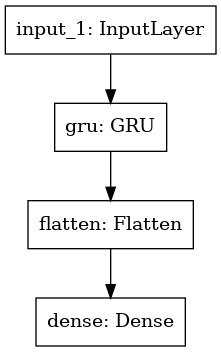

In [10]:
tf.keras.utils.plot_model(model)

### Training the model. 

The loss function used will be 'Categorical_CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.

We will be training for 100 epochs starting with learning_rate = 0.001 and batch_size = 64.

In [11]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model,history

In [12]:
model,history = train_model(model, X_train, y_train,X_test, y_test, save_to= './', epoch = 40) 

Epoch 1/40
47/47 [==============================] - 362s 8s/step - loss: 80.5641 - accuracy: 0.6353 - val_loss: 6.7063 - val_accuracy: 0.9219

Epoch 00001: val_accuracy improved from -inf to 0.92188, saving model to ./_best_model.h5
Epoch 2/40
47/47 [==============================] - 359s 8s/step - loss: 10.7318 - accuracy: 0.8962 - val_loss: 2.4050 - val_accuracy: 0.9438

Epoch 00002: val_accuracy improved from 0.92188 to 0.94375, saving model to ./_best_model.h5
Epoch 3/40
47/47 [==============================] - 358s 8s/step - loss: 4.2519 - accuracy: 0.9277 - val_loss: 1.2607 - val_accuracy: 0.9672

Epoch 00003: val_accuracy improved from 0.94375 to 0.96719, saving model to ./_best_model.h5
Epoch 4/40
47/47 [==============================] - 357s 8s/step - loss: 0.7786 - accuracy: 0.9740 - val_loss: 0.9202 - val_accuracy: 0.9766

Epoch 00004: val_accuracy improved from 0.96719 to 0.97656, saving model to ./_best_model.h5
Epoch 5/40
47/47 [==============================] - 355s 8s/s

### Plotting the validation curves 

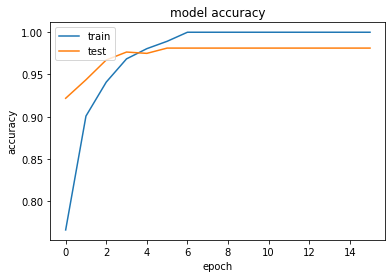

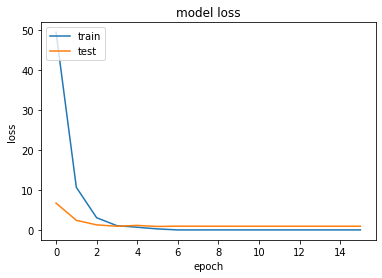

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating the model 

1. Test accuracy

In [14]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 98.125%


2. Confusion matrix along with classification reports (includes metrics like precision, F1-score)

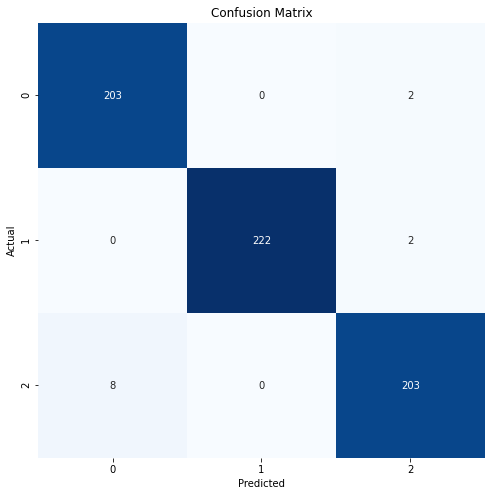

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       205
           1       1.00      0.99      1.00       224
           2       0.98      0.96      0.97       211

    accuracy                           0.98       640
   macro avg       0.98      0.98      0.98       640
weighted avg       0.98      0.98      0.98       640



In [15]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## Please upvote if you found it useful :) 